# Examples for rank 4 array

Pass COO-like data to `SparseTensor` with one array of indices for each dimension.

The default is to create CSF sparse data structure where all but the last dimension are doubly compressed.

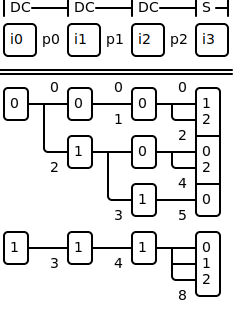

In [1]:
from sparsetensorviz import SparseTensor
import itertools
import IPython

indices = [
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [1, 2, 0, 2, 0, 0, 1, 2],
]
sp = SparseTensor(indices)
# Display as SVG diagram
sp

In [2]:
sp.indices

[array([0, 1]),
 array([0, 1, 1]),
 array([0, 0, 1, 1]),
 array([1, 2, 0, 2, 0, 0, 1, 2])]

In [3]:
sp.pointers

[array([0, 2, 3]), array([0, 1, 3, 4]), array([0, 2, 4, 5, 8])]

In [4]:
# Can also display as ASCII diagram
print(sp)

|DC ----|DC ----|DC ----|S -|
.---.   .---.   .---.   .---.
|i0 |p0 |i1 |p1 |i2 |p2 |i3 |
`---'   `---'   `---'   `---'
.--.  0 .--.  0 .--.  0 .--.
|0 |-+--|0 |----|0 |-+--|1 |
`--' |  `--'  1 `--' `--|2 |
     |  .--.    .--.  2 |--|
     `--|1 |-+--|0 |-+--|0 |
      2 `--' |  `--' `--|2 |
             |  .--.  4 |--|
             `--|1 |----|0 |
              3 `--'  5 `--'
.--.    .--.    .--.    .--.
|1 |----|1 |----|1 |-+--|0 |
`--'  3 `--'  4 `--' |--|1 |
                     `--|2 |
                      8 `--'


This diagram forms a tree-like structure where the first dimension is on the left and last dimension is on the right.

Index values are in boxes, and pointer values are next to edges.

We can choose how each dimension is compressed with any of the following:
- **`S`, "sparse"**: like COO; indices are "aligned" to the following dimension indices or values.
  - Uses: `indices_i`
- **`C`, "compressed"**: like CSR; fast lookup by index into pointers to the next dimension.
  - Uses: `pointers_i`
  - Makes `pointers_{i-1}` unnecessary
- **`DC`, "doubly compressed"**: like DCSR; store unique index values and pointers to the next dimension.
  - Uses: `pointers_i`, `indices_i`

Currently, the final dimension must be sparse, **`S`**.

Hence, describing the structures of **CSR, CSC, DCSR, and DCSC** give us... CSR, CSC, DCSR, and DCSC (let's address the final "R" and "C" later).

In [5]:
sp.bundled_groups

['HyperSparse(1)', 'HyperSparse(1)', 'HyperSparse(1)', 'Coord(1)']

In [6]:
sp.structure

[doubly_compressed, doubly_compressed, doubly_compressed, sparse]

In [7]:
sp.abbreviation

'DC-DC-DC-S'

#### We can also use TACO-like dimensions names
`"dense"`, `"compressed"`, `"compressed-nonunique"`, and `"singleton"`

In [8]:
sp = SparseTensor.from_taco(
    indices, structure=["compressed-nonunique", "singleton", "dense", "compressed"]
)
sp.structure

[sparse, sparse, compressed, sparse]

In [9]:
sp.taco_structure

['compressed-nonunique', 'singleton', 'dense', 'compressed']

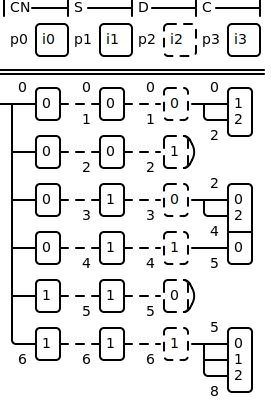

In [10]:
sp.taco_view

## Display all sparse structures that are independent of shape

This includes sparse structures that have no "compressed sparse" (**`C`**) dimensions.

Hyphonated connecting lines indicate pointers that don't need stored.

In [11]:
# Helper function
seen_taco = {}


def display_header(st, *, align=False, seen_taco=None):
    key = tuple(st.taco_structure)
    if seen_taco and key in seen_taco:
        seen_text = "  # (seen)"
    else:
        seen_text = ""
        if seen_taco is not None:
            seen_taco[key] = st.structure
    bundled = ", ".join(st.bundled_groups)
    if align:
        widths = [max(len(str(x)), len(y)) for x, y in zip(st.structure, st.taco_structure)]
        structure = ", ".join(
            str(sparse).rjust(width) for sparse, width in zip(st.structure, widths)
        )
        taco_structure = ", ".join(
            sparse.rjust(width) for sparse, width in zip(st.taco_structure, widths)
        )
        text = (
            "```\n"
            f"bundled_groups = [{bundled}]\n\n"
            f"structure      = [{structure}]\n\n"
            f"taco_structure = [{taco_structure}]{seen_text}\n\n"
            "```"
        )
    else:
        taco_structure = ", ".join(st.taco_structure)
        text = (
            "```\n"
            f"bundled_groups = [{bundled}]\n\n"
            f"structure      = {st.structure}\n\n"
            f"taco_structure = [{taco_structure}]{seen_text}\n\n"
            "```"
        )
    IPython.display.display(IPython.display.Markdown(text))

# `S-S-S-S`

```
bundled_groups = [Coord(4)]

structure      = [sparse, sparse, sparse, sparse]

taco_structure = [compressed-nonunique, singleton, singleton, singleton]

```

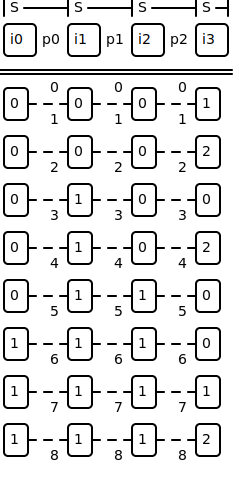

# `S-S-DC-S`

```
bundled_groups = [HyperSparse(3), Coord(1)]

structure      = [sparse, sparse, doubly_compressed, sparse]

taco_structure = [compressed, singleton, singleton, compressed]

```

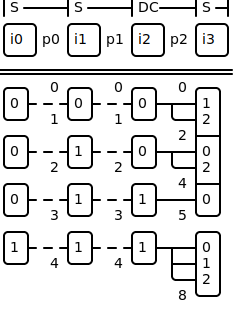

# `S-DC-S-S`

```
bundled_groups = [HyperSparse(2), Coord(2)]

structure      = [sparse, doubly_compressed, sparse, sparse]

taco_structure = [compressed, singleton, compressed-nonunique, singleton]

```

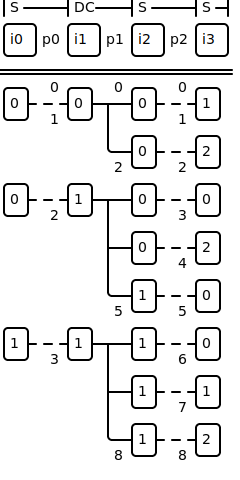

# `S-DC-DC-S`

```
bundled_groups = [HyperSparse(2), HyperSparse(1), Coord(1)]

structure      = [sparse, doubly_compressed, doubly_compressed, sparse]

taco_structure = [compressed, singleton, compressed, compressed]

```

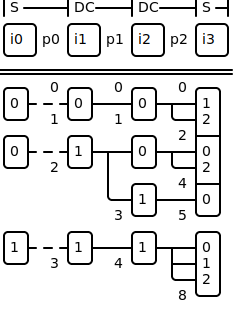

# `DC-S-S-S`

```
bundled_groups = [HyperSparse(1), Coord(3)]

structure      = [doubly_compressed, sparse, sparse, sparse]

taco_structure = [compressed, compressed-nonunique, singleton, singleton]

```

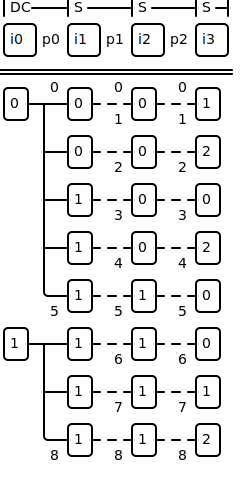

# `DC-S-DC-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(2), Coord(1)]

structure      = [doubly_compressed, sparse, doubly_compressed, sparse]

taco_structure = [compressed, compressed, singleton, compressed]

```

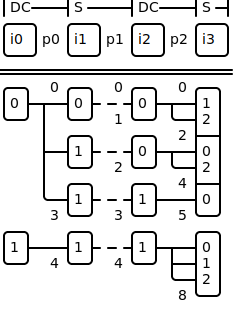

# `DC-DC-S-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(1), Coord(2)]

structure      = [doubly_compressed, doubly_compressed, sparse, sparse]

taco_structure = [compressed, compressed, compressed-nonunique, singleton]

```

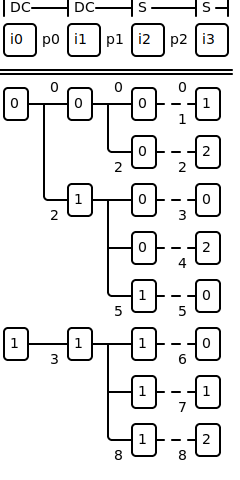

# `DC-DC-DC-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(1), HyperSparse(1), Coord(1)]

structure      = [doubly_compressed, doubly_compressed, doubly_compressed, sparse]

taco_structure = [compressed, compressed, compressed, compressed]

```

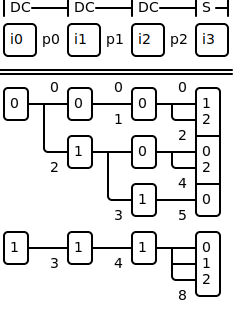

In [12]:
sparsities = ["S", "DC"]
for sparsity in itertools.product(sparsities, sparsities, sparsities, ["S"]):
    structure = "-".join(sparsity)
    IPython.display.display(IPython.display.Markdown(f"# `{structure}`"))
    st = SparseTensor(indices, structure=structure)
    display_header(st, seen_taco=seen_taco)
    IPython.display.display(st)

## Display sparse structures, `shape=(2, 2, 2, 3)`

Hyphonated boxes indicate indices that don't need stored.

For compressed sparse dimensions, `C`, some repeated pointer values may be skipped if there is no room

# `S-S-C-S`

```
bundled_groups = [Coord(2, expanded=True), Sparse(1), Coord(1)]

structure      = [sparse, sparse, compressed, sparse]

taco_structure = [compressed-nonunique, singleton, dense, compressed]

```

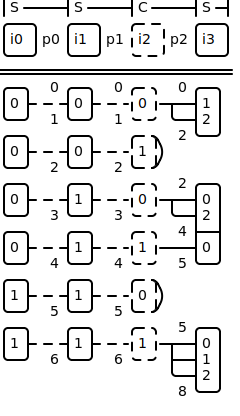

# `S-C-S-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(1), Coord(2)]

structure      = [sparse, compressed, sparse, sparse]

taco_structure = [compressed-nonunique, dense, compressed-nonunique, singleton]

```

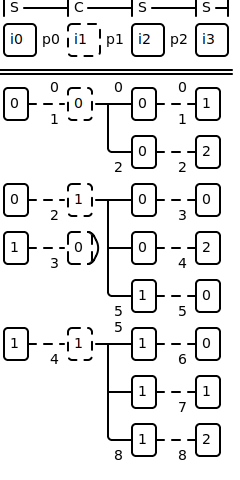

# `S-C-C-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(2), Coord(1)]

structure      = [sparse, compressed, compressed, sparse]

taco_structure = [compressed-nonunique, dense, dense, compressed]

```

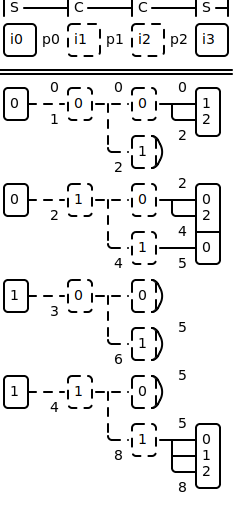

# `S-C-DC-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(1), HyperSparse(1), Coord(1)]

structure      = [sparse, compressed, doubly_compressed, sparse]

taco_structure = [compressed-nonunique, dense, compressed, compressed]

```

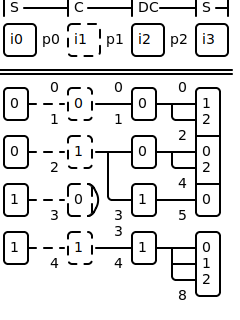

# `S-DC-C-S`

```
bundled_groups = [Coord(2), Sparse(1), Coord(1)]

structure      = [sparse, doubly_compressed, compressed, sparse]

taco_structure = [compressed, singleton, dense, compressed]

```

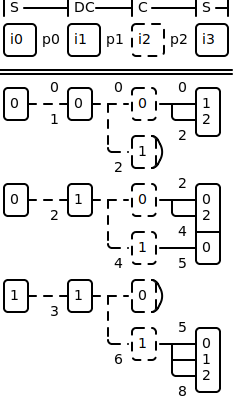

# `C-S-S-S`

```
bundled_groups = [Sparse(1), Coord(3)]

structure      = [compressed, sparse, sparse, sparse]

taco_structure = [dense, compressed-nonunique, singleton, singleton]

```

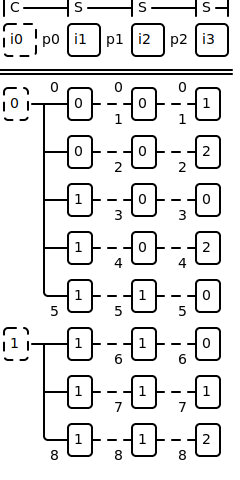

# `C-S-C-S`

```
bundled_groups = [Sparse(1), Coord(1, expanded=True), Sparse(1), Coord(1)]

structure      = [compressed, sparse, compressed, sparse]

taco_structure = [dense, compressed-nonunique, dense, compressed]

```

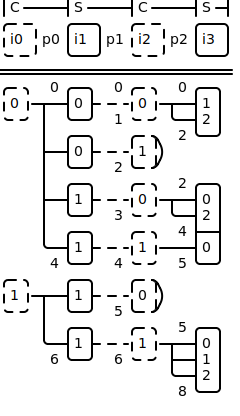

# `C-S-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(2), Coord(1)]

structure      = [compressed, sparse, doubly_compressed, sparse]

taco_structure = [dense, compressed, singleton, compressed]

```

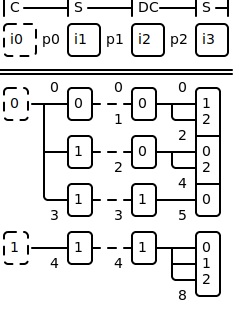

# `C-C-S-S`

```
bundled_groups = [Sparse(2), Coord(2)]

structure      = [compressed, compressed, sparse, sparse]

taco_structure = [dense, dense, compressed-nonunique, singleton]

```

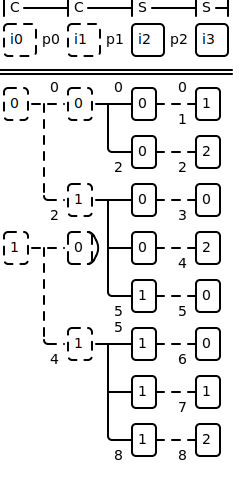

# `C-C-C-S`

```
bundled_groups = [Sparse(3), Coord(1)]

structure      = [compressed, compressed, compressed, sparse]

taco_structure = [dense, dense, dense, compressed]

```

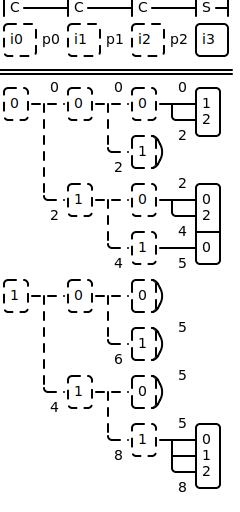

# `C-C-DC-S`

```
bundled_groups = [Sparse(2), HyperSparse(1), Coord(1)]

structure      = [compressed, compressed, doubly_compressed, sparse]

taco_structure = [dense, dense, compressed, compressed]

```

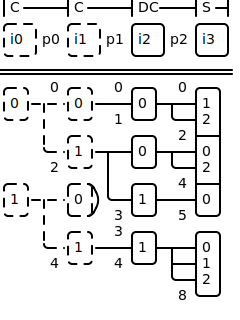

# `C-DC-S-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), Coord(2)]

structure      = [compressed, doubly_compressed, sparse, sparse]

taco_structure = [dense, compressed, compressed-nonunique, singleton]

```

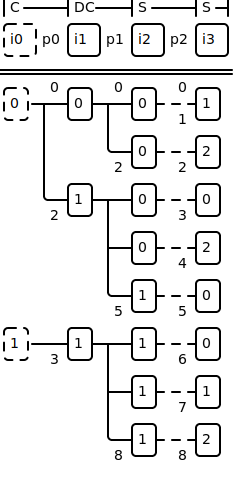

# `C-DC-C-S`

```
bundled_groups = [Sparse(1), Coord(1), Sparse(1), Coord(1)]

structure      = [compressed, doubly_compressed, compressed, sparse]

taco_structure = [dense, compressed, dense, compressed]

```

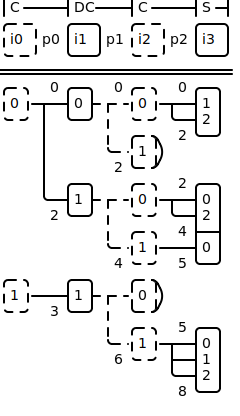

# `C-DC-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), HyperSparse(1), Coord(1)]

structure      = [compressed, doubly_compressed, doubly_compressed, sparse]

taco_structure = [dense, compressed, compressed, compressed]

```

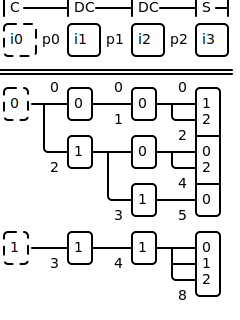

# `DC-S-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1, expanded=True), Sparse(1), Coord(1)]

structure      = [doubly_compressed, sparse, compressed, sparse]

taco_structure = [compressed, compressed-nonunique, dense, compressed]

```

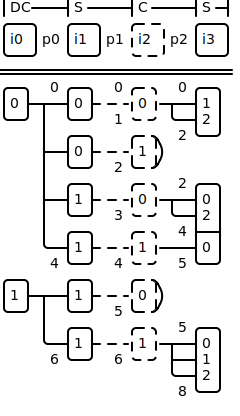

# `DC-C-S-S`

```
bundled_groups = [Coord(1), Sparse(1), Coord(2)]

structure      = [doubly_compressed, compressed, sparse, sparse]

taco_structure = [compressed, dense, compressed-nonunique, singleton]

```

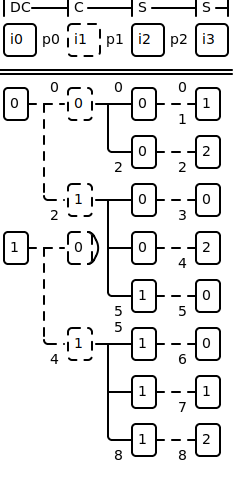

# `DC-C-C-S`

```
bundled_groups = [Coord(1), Sparse(2), Coord(1)]

structure      = [doubly_compressed, compressed, compressed, sparse]

taco_structure = [compressed, dense, dense, compressed]

```

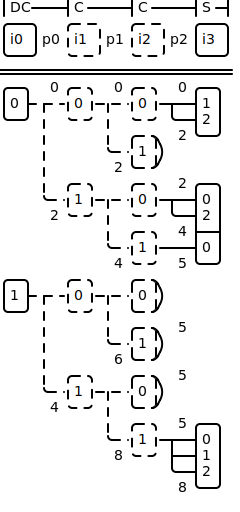

# `DC-C-DC-S`

```
bundled_groups = [Coord(1), Sparse(1), HyperSparse(1), Coord(1)]

structure      = [doubly_compressed, compressed, doubly_compressed, sparse]

taco_structure = [compressed, dense, compressed, compressed]

```

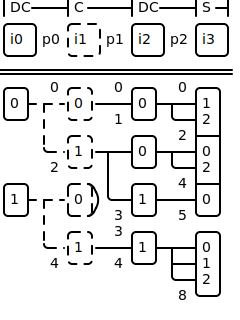

# `DC-DC-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1), Sparse(1), Coord(1)]

structure      = [doubly_compressed, doubly_compressed, compressed, sparse]

taco_structure = [compressed, compressed, dense, compressed]

```

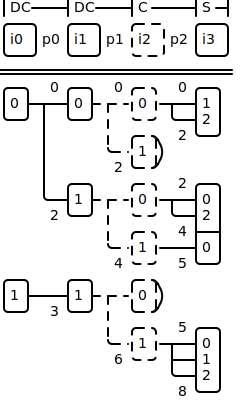

In [13]:
sparsities = ["S", "C", "DC"]
for sparsity in itertools.product(sparsities, sparsities, sparsities, ["S"]):
    if "C" not in sparsity:
        continue
    structure = "-".join(sparsity)
    IPython.display.display(IPython.display.Markdown(f"# `{structure}`"))
    st = SparseTensor(indices, shape=(2, 2, 2, 3), structure=structure)
    display_header(st)
    IPython.display.display(st)

## Display sparse structures, `shape=(3, 3, 3, 3)`

# `S-S-C-S`

```
bundled_groups = [Coord(2, expanded=True), Sparse(1), Coord(1)]

structure      = [sparse, sparse, compressed, sparse]

taco_structure = [compressed-nonunique, singleton, dense, compressed]

```

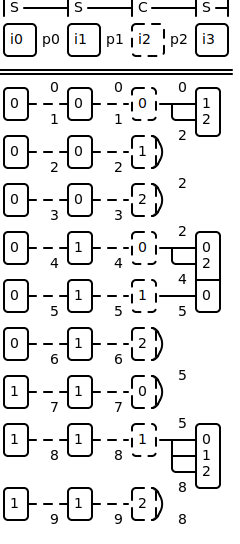

# `S-C-S-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(1), Coord(2)]

structure      = [sparse, compressed, sparse, sparse]

taco_structure = [compressed-nonunique, dense, compressed-nonunique, singleton]

```

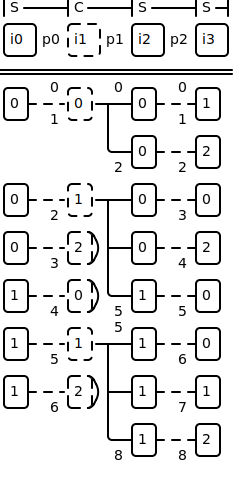

# `S-C-C-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(2), Coord(1)]

structure      = [sparse, compressed, compressed, sparse]

taco_structure = [compressed-nonunique, dense, dense, compressed]

```

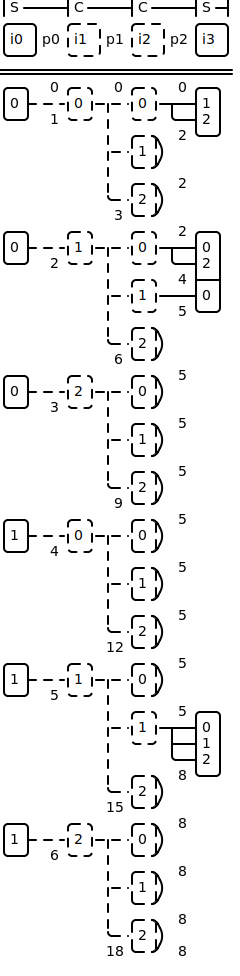

# `S-C-DC-S`

```
bundled_groups = [Coord(1, expanded=True), Sparse(1), HyperSparse(1), Coord(1)]

structure      = [sparse, compressed, doubly_compressed, sparse]

taco_structure = [compressed-nonunique, dense, compressed, compressed]

```

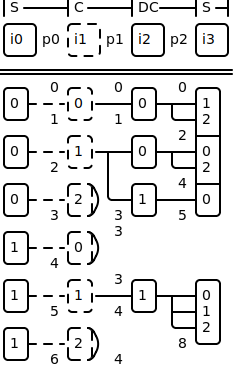

# `S-DC-C-S`

```
bundled_groups = [Coord(2), Sparse(1), Coord(1)]

structure      = [sparse, doubly_compressed, compressed, sparse]

taco_structure = [compressed, singleton, dense, compressed]

```

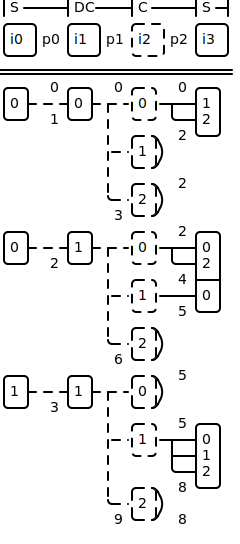

# `C-S-S-S`

```
bundled_groups = [Sparse(1), Coord(3)]

structure      = [compressed, sparse, sparse, sparse]

taco_structure = [dense, compressed-nonunique, singleton, singleton]

```

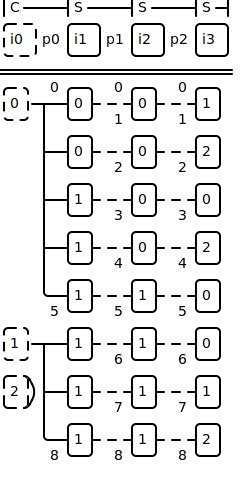

# `C-S-C-S`

```
bundled_groups = [Sparse(1), Coord(1, expanded=True), Sparse(1), Coord(1)]

structure      = [compressed, sparse, compressed, sparse]

taco_structure = [dense, compressed-nonunique, dense, compressed]

```

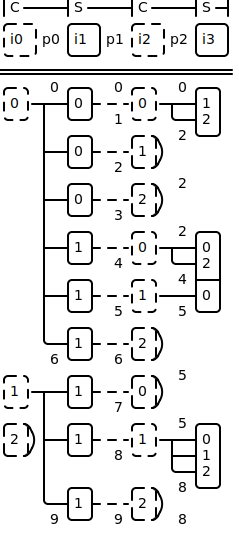

# `C-S-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(2), Coord(1)]

structure      = [compressed, sparse, doubly_compressed, sparse]

taco_structure = [dense, compressed, singleton, compressed]

```

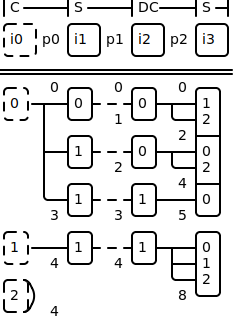

# `C-C-S-S`

```
bundled_groups = [Sparse(2), Coord(2)]

structure      = [compressed, compressed, sparse, sparse]

taco_structure = [dense, dense, compressed-nonunique, singleton]

```

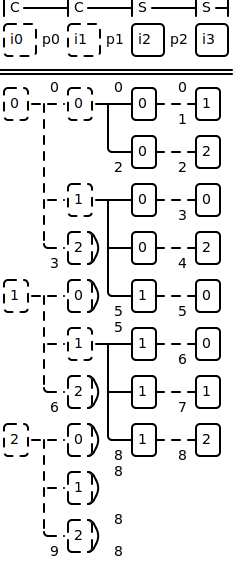

# `C-C-C-S`

```
bundled_groups = [Sparse(3), Coord(1)]

structure      = [compressed, compressed, compressed, sparse]

taco_structure = [dense, dense, dense, compressed]

```

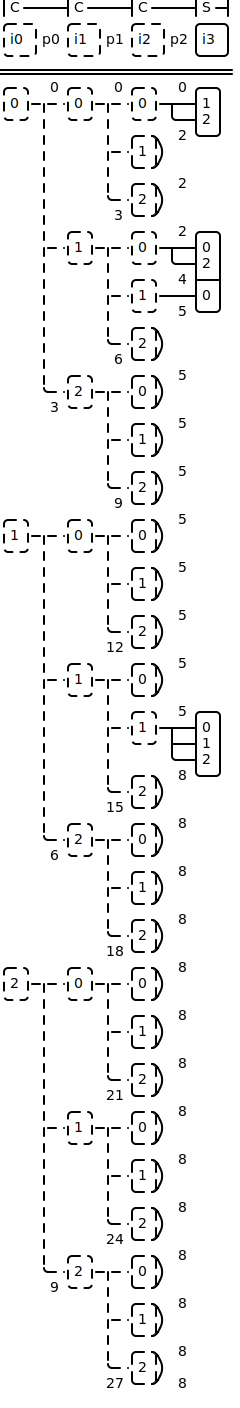

# `C-C-DC-S`

```
bundled_groups = [Sparse(2), HyperSparse(1), Coord(1)]

structure      = [compressed, compressed, doubly_compressed, sparse]

taco_structure = [dense, dense, compressed, compressed]

```

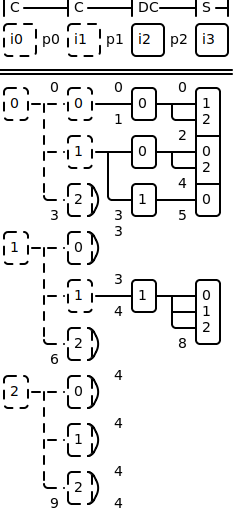

# `C-DC-S-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), Coord(2)]

structure      = [compressed, doubly_compressed, sparse, sparse]

taco_structure = [dense, compressed, compressed-nonunique, singleton]

```

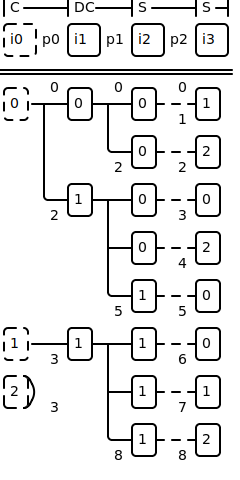

# `C-DC-C-S`

```
bundled_groups = [Sparse(1), Coord(1), Sparse(1), Coord(1)]

structure      = [compressed, doubly_compressed, compressed, sparse]

taco_structure = [dense, compressed, dense, compressed]

```

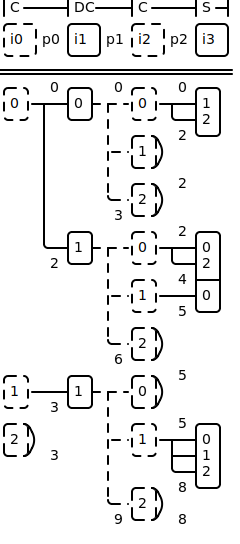

# `C-DC-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), HyperSparse(1), Coord(1)]

structure      = [compressed, doubly_compressed, doubly_compressed, sparse]

taco_structure = [dense, compressed, compressed, compressed]

```

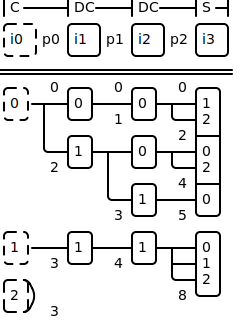

# `DC-S-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1, expanded=True), Sparse(1), Coord(1)]

structure      = [doubly_compressed, sparse, compressed, sparse]

taco_structure = [compressed, compressed-nonunique, dense, compressed]

```

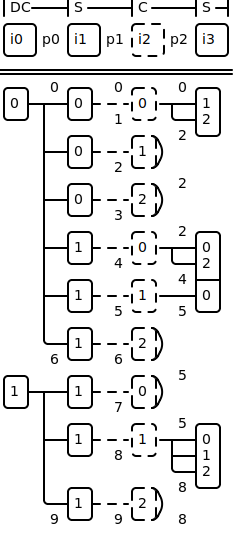

# `DC-C-S-S`

```
bundled_groups = [Coord(1), Sparse(1), Coord(2)]

structure      = [doubly_compressed, compressed, sparse, sparse]

taco_structure = [compressed, dense, compressed-nonunique, singleton]

```

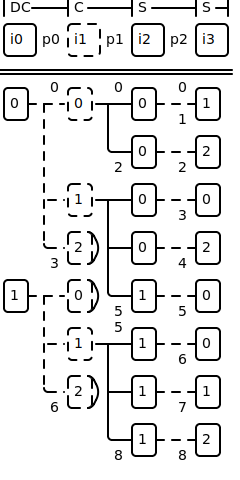

# `DC-C-C-S`

```
bundled_groups = [Coord(1), Sparse(2), Coord(1)]

structure      = [doubly_compressed, compressed, compressed, sparse]

taco_structure = [compressed, dense, dense, compressed]

```

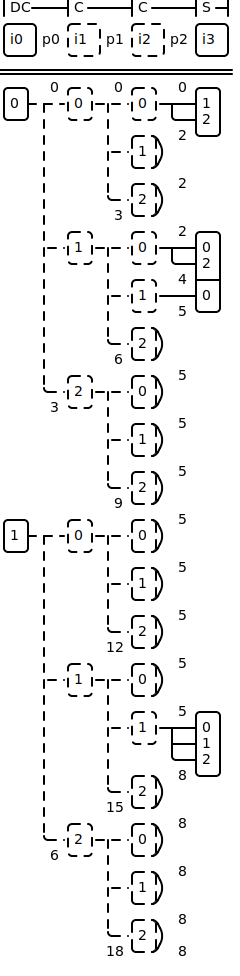

# `DC-C-DC-S`

```
bundled_groups = [Coord(1), Sparse(1), HyperSparse(1), Coord(1)]

structure      = [doubly_compressed, compressed, doubly_compressed, sparse]

taco_structure = [compressed, dense, compressed, compressed]

```

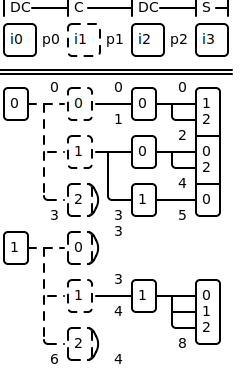

# `DC-DC-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1), Sparse(1), Coord(1)]

structure      = [doubly_compressed, doubly_compressed, compressed, sparse]

taco_structure = [compressed, compressed, dense, compressed]

```

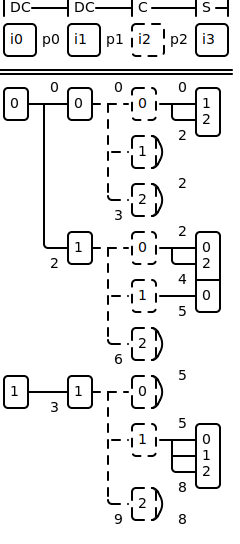

In [14]:
for sparsity in itertools.product(sparsities, sparsities, sparsities, ["S"]):
    if "C" not in sparsity:
        continue
    structure = "-".join(sparsity)
    IPython.display.display(IPython.display.Markdown(f"# `{structure}`"))
    st = SparseTensor(indices, shape=(3, 3, 3, 3), structure=structure)
    display_header(st, seen_taco=seen_taco)
    IPython.display.display(st)

# voilà!
<hr>

## ✨ _Bonus: brain teasers_ ✨

#### Are any of these valid TACO (or MLIR sparse tensor) formats, and, if so, what do they mean?
```
- [compressed, compressed, compressed-nonunique, compressed]
- [compressed, compressed-nonunique, compressed, compressed]
- [compressed, compressed-nonunique, compressed-nonunique, compressed]
- [compressed, compressed-nonunique, compressed-nonunique, singleton]
- [compressed, compressed-nonunique, singleton, compressed]
- [compressed, dense, compressed-nonunique, compressed]
- [compressed, singleton, compressed-nonunique, compressed]
- [compressed-nonunique, compressed, compressed, compressed]
- [compressed-nonunique, compressed, compressed-nonunique, compressed]
- [compressed-nonunique, compressed, compressed-nonunique, singleton]
- [compressed-nonunique, compressed, dense, compressed]
- [compressed-nonunique, compressed, singleton, compressed]
- [compressed-nonunique, compressed-nonunique, compressed, compressed]
- [compressed-nonunique, compressed-nonunique, compressed-nonunique, compressed]
- [compressed-nonunique, compressed-nonunique, compressed-nonunique, singleton]
- [compressed-nonunique, compressed-nonunique, dense, compressed]
- [compressed-nonunique, compressed-nonunique, singleton, compressed]
- [compressed-nonunique, compressed-nonunique, singleton, singleton]
- [compressed-nonunique, dense, compressed-nonunique, compressed]
- [compressed-nonunique, singleton, compressed, compressed]
- [compressed-nonunique, singleton, compressed-nonunique, compressed]
- [compressed-nonunique, singleton, compressed-nonunique, singleton]
- [compressed-nonunique, singleton, singleton, compressed]
- [dense, compressed, compressed-nonunique, compressed]
- [dense, compressed-nonunique, compressed, compressed]
- [dense, compressed-nonunique, compressed-nonunique, compressed]
- [dense, compressed-nonunique, compressed-nonunique, singleton]
- [dense, compressed-nonunique, singleton, compressed]
- [dense, dense, compressed-nonunique, compressed]
```

#### What about these?
```
- [compressed, compressed, compressed, compressed-nonunique]
- [compressed, compressed, compressed-nonunique, compressed-nonunique]
- [compressed, compressed, dense, compressed-nonunique]
- [compressed, compressed, singleton, compressed-nonunique]
- [compressed, compressed-nonunique, compressed, compressed-nonunique]
- [compressed, compressed-nonunique, compressed-nonunique, compressed-nonunique]
- [compressed, compressed-nonunique, dense, compressed-nonunique]
- [compressed, compressed-nonunique, singleton, compressed-nonunique]
- [compressed, dense, compressed, compressed-nonunique]
- [compressed, dense, compressed-nonunique, compressed-nonunique]
- [compressed, dense, dense, compressed-nonunique]
- [compressed, dense, singleton, compressed-nonunique]
- [compressed, singleton, compressed, compressed-nonunique]
- [compressed, singleton, compressed-nonunique, compressed-nonunique]
- [compressed, singleton, dense, compressed-nonunique]
- [compressed, singleton, singleton, compressed-nonunique]
- [compressed-nonunique, compressed, compressed, compressed-nonunique]
- [compressed-nonunique, compressed, compressed-nonunique, compressed-nonunique]
- [compressed-nonunique, compressed, dense, compressed-nonunique]
- [compressed-nonunique, compressed, singleton, compressed-nonunique]
- [compressed-nonunique, compressed-nonunique, compressed, compressed-nonunique]
- [compressed-nonunique, compressed-nonunique, compressed-nonunique, compressed-nonunique]
- [compressed-nonunique, compressed-nonunique, dense, compressed-nonunique]
- [compressed-nonunique, compressed-nonunique, singleton, compressed-nonunique]
- [compressed-nonunique, dense, compressed, compressed-nonunique]
- [compressed-nonunique, dense, compressed-nonunique, compressed-nonunique]
- [compressed-nonunique, dense, dense, compressed-nonunique]
- [compressed-nonunique, dense, singleton, compressed-nonunique]
- [compressed-nonunique, singleton, compressed, compressed-nonunique]
- [compressed-nonunique, singleton, compressed-nonunique, compressed-nonunique]
- [compressed-nonunique, singleton, dense, compressed-nonunique]
- [compressed-nonunique, singleton, singleton, compressed-nonunique]
- [dense, compressed, compressed, compressed-nonunique]
- [dense, compressed, compressed-nonunique, compressed-nonunique]
- [dense, compressed, dense, compressed-nonunique]
- [dense, compressed, singleton, compressed-nonunique]
- [dense, compressed-nonunique, compressed, compressed-nonunique]
- [dense, compressed-nonunique, compressed-nonunique, compressed-nonunique]
- [dense, compressed-nonunique, dense, compressed-nonunique]
- [dense, compressed-nonunique, singleton, compressed-nonunique]
- [dense, dense, compressed, compressed-nonunique]
- [dense, dense, compressed-nonunique, compressed-nonunique]
- [dense, dense, dense, compressed-nonunique]
- [dense, dense, singleton, compressed-nonunique]
- [dense, singleton, compressed, compressed-nonunique]
- [dense, singleton, compressed-nonunique, compressed-nonunique]
- [dense, singleton, dense, compressed-nonunique]
- [dense, singleton, singleton, compressed-nonunique]
```

#### Or these?
```
- [singleton, compressed, compressed, compressed]
- [singleton, compressed, compressed, compressed-nonunique]
- [singleton, compressed, compressed, singleton]
- [singleton, compressed, compressed-nonunique, compressed]
- [singleton, compressed, compressed-nonunique, compressed-nonunique]
- [singleton, compressed, compressed-nonunique, singleton]
- [singleton, compressed, dense, compressed]
- [singleton, compressed, dense, compressed-nonunique]
- [singleton, compressed, dense, singleton]
- [singleton, compressed, singleton, compressed]
- [singleton, compressed, singleton, compressed-nonunique]
- [singleton, compressed, singleton, singleton]
- [singleton, compressed-nonunique, compressed, compressed]
- [singleton, compressed-nonunique, compressed, compressed-nonunique]
- [singleton, compressed-nonunique, compressed, singleton]
- [singleton, compressed-nonunique, compressed-nonunique, compressed]
- [singleton, compressed-nonunique, compressed-nonunique, compressed-nonunique]
- [singleton, compressed-nonunique, compressed-nonunique, singleton]
- [singleton, compressed-nonunique, dense, compressed]
- [singleton, compressed-nonunique, dense, compressed-nonunique]
- [singleton, compressed-nonunique, dense, singleton]
- [singleton, compressed-nonunique, singleton, compressed]
- [singleton, compressed-nonunique, singleton, compressed-nonunique]
- [singleton, compressed-nonunique, singleton, singleton]
- [singleton, dense, compressed, compressed]
- [singleton, dense, compressed, compressed-nonunique]
- [singleton, dense, compressed, singleton]
- [singleton, dense, compressed-nonunique, compressed]
- [singleton, dense, compressed-nonunique, compressed-nonunique]
- [singleton, dense, compressed-nonunique, singleton]
- [singleton, dense, dense, compressed]
- [singleton, dense, dense, compressed-nonunique]
- [singleton, dense, dense, singleton]
- [singleton, dense, singleton, compressed]
- [singleton, dense, singleton, compressed-nonunique]
- [singleton, dense, singleton, singleton]
- [singleton, singleton, compressed, compressed]
- [singleton, singleton, compressed, compressed-nonunique]
- [singleton, singleton, compressed, singleton]
- [singleton, singleton, compressed-nonunique, compressed]
- [singleton, singleton, compressed-nonunique, compressed-nonunique]
- [singleton, singleton, compressed-nonunique, singleton]
- [singleton, singleton, dense, compressed]
- [singleton, singleton, dense, compressed-nonunique]
- [singleton, singleton, dense, singleton]
- [singleton, singleton, singleton, compressed]
- [singleton, singleton, singleton, compressed-nonunique]
- [singleton, singleton, singleton, singleton]
```

#### Or, finally, these?
```
- [compressed, compressed, compressed, singleton]
- [compressed, compressed, dense, singleton]
- [compressed, compressed, singleton, singleton]
- [compressed, compressed-nonunique, compressed, singleton]
- [compressed, compressed-nonunique, dense, singleton]
- [compressed, dense, compressed, singleton]
- [compressed, dense, dense, singleton]
- [compressed, dense, singleton, compressed]
- [compressed, dense, singleton, singleton]
- [compressed, singleton, compressed, singleton]
- [compressed, singleton, dense, singleton]
- [compressed, singleton, singleton, singleton]
- [compressed-nonunique, compressed, compressed, singleton]
- [compressed-nonunique, compressed, dense, singleton]
- [compressed-nonunique, compressed, singleton, singleton]
- [compressed-nonunique, compressed-nonunique, compressed, singleton]
- [compressed-nonunique, compressed-nonunique, dense, singleton]
- [compressed-nonunique, dense, compressed, singleton]
- [compressed-nonunique, dense, dense, singleton]
- [compressed-nonunique, dense, singleton, compressed]
- [compressed-nonunique, dense, singleton, singleton]
- [compressed-nonunique, singleton, compressed, singleton]
- [compressed-nonunique, singleton, dense, singleton]
- [dense, compressed, compressed, singleton]
- [dense, compressed, dense, singleton]
- [dense, compressed, singleton, singleton]
- [dense, compressed-nonunique, compressed, singleton]
- [dense, compressed-nonunique, dense, singleton]
- [dense, dense, compressed, singleton]
- [dense, dense, dense, singleton]
- [dense, dense, singleton, compressed]
- [dense, dense, singleton, singleton]
- [dense, singleton, compressed, compressed]
- [dense, singleton, compressed, singleton]
- [dense, singleton, compressed-nonunique, compressed]
- [dense, singleton, compressed-nonunique, singleton]
- [dense, singleton, dense, compressed]
- [dense, singleton, dense, singleton]
- [dense, singleton, singleton, compressed]
- [dense, singleton, singleton, singleton]
```

In [15]:
# Structure conversions from TACO to ours
for key in sorted(seen_taco):
    print(list(key))
    print(seen_taco[key])
    print()

['compressed', 'compressed', 'compressed', 'compressed']
[doubly_compressed, doubly_compressed, doubly_compressed, sparse]

['compressed', 'compressed', 'compressed-nonunique', 'singleton']
[doubly_compressed, doubly_compressed, sparse, sparse]

['compressed', 'compressed', 'dense', 'compressed']
[doubly_compressed, doubly_compressed, compressed, sparse]

['compressed', 'compressed', 'singleton', 'compressed']
[doubly_compressed, sparse, doubly_compressed, sparse]

['compressed', 'compressed-nonunique', 'dense', 'compressed']
[doubly_compressed, sparse, compressed, sparse]

['compressed', 'compressed-nonunique', 'singleton', 'singleton']
[doubly_compressed, sparse, sparse, sparse]

['compressed', 'dense', 'compressed', 'compressed']
[doubly_compressed, compressed, doubly_compressed, sparse]

['compressed', 'dense', 'compressed-nonunique', 'singleton']
[doubly_compressed, compressed, sparse, sparse]

['compressed', 'dense', 'dense', 'compressed']
[doubly_compressed, compressed, compress